# Yu Darvish: Pitching Evolution (2021-2025)

**パドレス在籍5年間の投球スタイル変化を追う**

- 球種配分の年次変化（何を増やし、何を減らしたか）
- 球速・スピンレートの経年推移
- スタミナパターンの変化（イニング別球速低下）
- 空振り率の進化（Whiff Rate）
- 2ストライク時の決め球戦略

---

In [1]:
!pip install pybaseball duckdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_pitcher
import duckdb

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# ====== Settings ======
PITCHER_ID = 506433  # Yu Darvish MLBAM ID
YEARS = [2021, 2022, 2023, 2024, 2025]
GAME_TYPE = 'R'  # Regular season only
# ======================

## 1. Data Acquisition (5 Seasons)

In [3]:
dfs = []
for year in YEARS:
    print(f'Fetching {year}...')
    df_year = statcast_pitcher(f'{year}-03-01', f'{year}-12-31', PITCHER_ID)
    df_year['season'] = year
    dfs.append(df_year)
    print(f'  {year}: {len(df_year):,} pitches')

df_raw = pd.concat(dfs, ignore_index=True)
print(f'\nTotal (raw): {len(df_raw):,} pitches')

# Filter regular season only
con = duckdb.connect()
df = con.execute(f"""
    SELECT * FROM df_raw WHERE game_type = '{GAME_TYPE}'
""").df()
print(f'Total (regular season): {len(df):,} pitches')

Fetching 2021...
Gathering Player Data
  2021: 2,842 pitches
Fetching 2022...
Gathering Player Data
  2022: 3,441 pitches
Fetching 2023...
Gathering Player Data
  2023: 2,219 pitches
Fetching 2024...
Gathering Player Data
  2024: 1,471 pitches
Fetching 2025...
Gathering Player Data
  2025: 1,292 pitches

Total (raw): 11,265 pitches
Total (regular season): 10,387 pitches


## 2. Data Summary

In [4]:
# === Text Summary (for Claude Code review) ===
summary = con.execute("""
    SELECT
        season,
        COUNT(*) as pitches,
        COUNT(DISTINCT game_date) as games,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(MAX(release_speed), 1) as max_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(DISTINCT pitch_type) as pitch_types
    FROM df
    GROUP BY season
    ORDER BY season
""").df()

print('=== Season-by-Season Overview ===')
print(summary.to_string(index=False))
print(f'\nTotal: {len(df):,} pitches across {len(YEARS)} seasons')

=== Season-by-Season Overview ===
 season  pitches  games  avg_velo  max_velo  avg_spin  pitch_types
   2021     2773     30      87.0      98.0    2615.0            9
   2022     2971     30      88.2      98.1    2511.0            9
   2023     2219     24      87.8      97.6    2506.0           10
   2024     1264     16      87.2      96.4    2417.0            9
   2025     1160     15      86.7      96.8    2348.0           10

Total: 10,387 pitches across 5 seasons


## 3. Pitch Arsenal Overview

In [5]:
# Which pitch types were used each year?
arsenal = con.execute("""
    SELECT
        season,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY season), 1) as pct,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY season, pitch_type
    ORDER BY season, count DESC
""").df()

print('=== Pitch Arsenal by Season ===')
for year in YEARS:
    year_data = arsenal[arsenal['season'] == year]
    print(f'\n--- {year} ---')
    print(year_data[['pitch_type', 'count', 'pct', 'avg_velo', 'avg_spin']].to_string(index=False))

=== Pitch Arsenal by Season ===

--- 2021 ---
pitch_type  count  pct  avg_velo  avg_spin
        SL    859 31.0      86.2    2792.0
        ST    630 22.8      81.6    2759.0
        FF    612 22.1      94.5    2513.0
        SI    229  8.3      94.0    2402.0
        FS    135  4.9      88.8    1455.0
        CU    127  4.6      71.9    2627.0
        KC    105  3.8      79.5    2822.0
        FC     70  2.5      91.3    2664.0
        CS      2  0.1      67.7    2482.0

--- 2022 ---
pitch_type  count  pct  avg_velo  avg_spin
        SL    936 31.5      86.0    2778.0
        FF    759 25.5      95.0    2419.0
        ST    457 15.4      82.7    2726.0
        SI    254  8.5      94.7    2264.0
        FS    221  7.4      89.2    1302.0
        FC    128  4.3      90.7    2577.0
        CU    119  4.0      72.8    2636.0
        KC     96  3.2      80.4    2793.0
        CS      1  0.0      64.2    2400.0

--- 2023 ---
pitch_type  count  pct  avg_velo  avg_spin
        SI    413 18.6 

## 4. Pitch Mix Evolution

**核心**: 5年間で球種の使い分けがどう変わったか

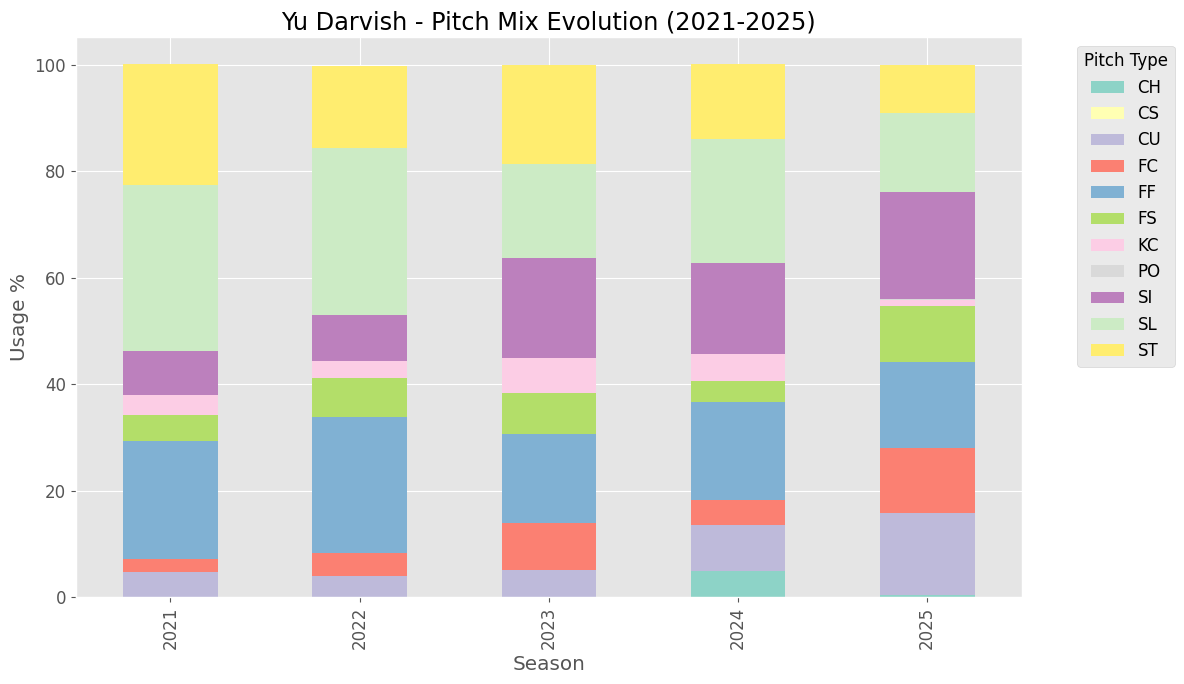


=== Pitch Mix Changes (% usage) ===
pitch_type   CH   CS    CU    FC    FF    FS   KC   PO    SI    SL    ST
season                                                                  
2021        0.0  0.1   4.6   2.5  22.1   4.9  3.8  0.0   8.3  31.0  22.8
2022        0.0  0.0   4.0   4.3  25.5   7.4  3.2  0.0   8.5  31.5  15.4
2023        0.1  0.0   5.0   8.9  16.7   7.7  6.6  0.0  18.6  17.7  18.6
2024        5.0  0.0   8.6   4.6  18.4   4.0  5.1  0.0  17.1  23.3  14.0
2025        0.5  0.0  15.4  12.2  16.0  10.6  1.2  0.1  20.0  14.9   9.1

=== Biggest Changes (2021 → 2025) ===
  SL: 31.0% → 14.9% (↓16.1%)
  ST: 22.8% → 9.1% (↓13.7%)
  FF: 22.1% → 16.0% (↓6.1%)
  KC: 3.8% → 1.2% (↓2.6%)
  FS: 4.9% → 10.6% (↑5.7%)
  FC: 2.5% → 12.2% (↑9.7%)
  CU: 4.6% → 15.4% (↑10.8%)
  SI: 8.3% → 20.0% (↑11.7%)


In [6]:
# Pivot for stacked bar chart
mix_pivot = arsenal.pivot_table(index='season', columns='pitch_type', values='pct', fill_value=0)

# Chart
mix_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')
plt.title('Yu Darvish - Pitch Mix Evolution (2021-2025)')
plt.xlabel('Season')
plt.ylabel('Usage %')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Pitch Mix Changes (% usage) ===')
print(mix_pivot.round(1).to_string())

# Year-over-year biggest changes
if len(YEARS) >= 2:
    first = mix_pivot.loc[YEARS[0]]
    last = mix_pivot.loc[YEARS[-1]]
    diff = (last - first).sort_values()
    print(f'\n=== Biggest Changes ({YEARS[0]} → {YEARS[-1]}) ===')
    for pitch, change in diff.items():
        if abs(change) >= 1.0:
            direction = '↑' if change > 0 else '↓'
            print(f'  {pitch}: {first[pitch]:.1f}% → {last[pitch]:.1f}% ({direction}{abs(change):.1f}%)')

## 5. Velocity Trends by Year

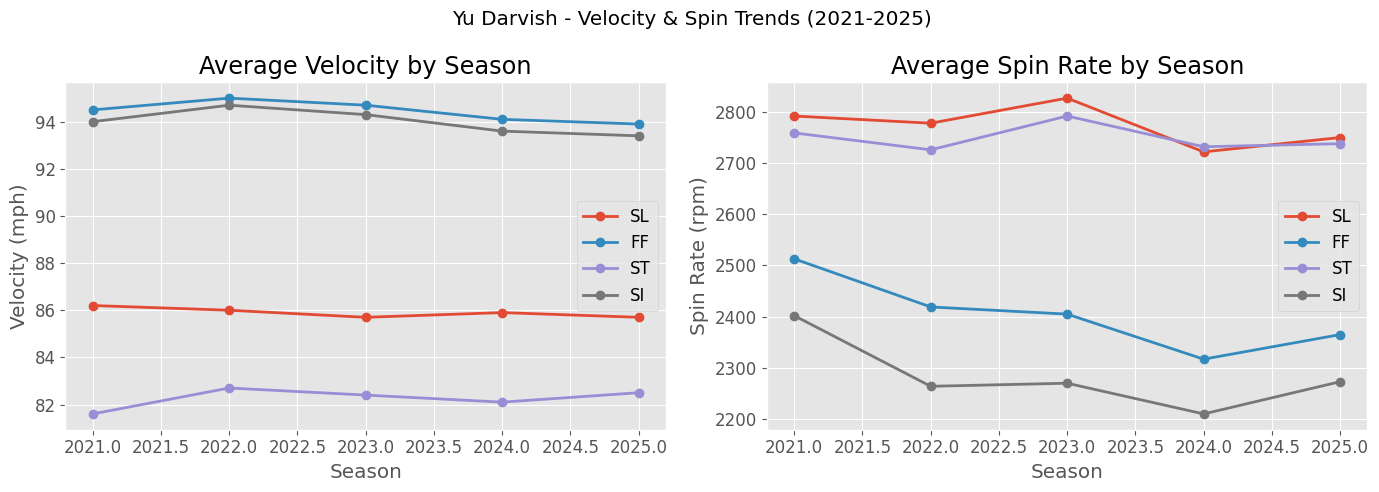


=== Velocity & Spin by Year (Top 4 Pitches) ===

SL:
 season  avg_velo  avg_spin  count
   2021      86.2    2792.0    859
   2022      86.0    2778.0    936
   2023      85.7    2827.0    392
   2024      85.9    2722.0    293
   2025      85.7    2750.0    173

FF:
 season  avg_velo  avg_spin  count
   2021      94.5    2513.0    612
   2022      95.0    2419.0    759
   2023      94.7    2405.0    371
   2024      94.1    2317.0    232
   2025      93.9    2365.0    185

ST:
 season  avg_velo  avg_spin  count
   2021      81.6    2759.0    630
   2022      82.7    2726.0    457
   2023      82.4    2792.0    412
   2024      82.1    2732.0    176
   2025      82.5    2738.0    105

SI:
 season  avg_velo  avg_spin  count
   2021      94.0    2402.0    229
   2022      94.7    2264.0    254
   2023      94.3    2270.0    413
   2024      93.6    2210.0    215
   2025      93.4    2273.0    232


In [7]:
# Fastball (FF) velocity trend across years
velo_by_year = con.execute("""
    SELECT
        season,
        pitch_type,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(*) as count
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY season, pitch_type
    ORDER BY season
""").df()

# Get top 4 most used pitches overall
top_pitches = con.execute("""
    SELECT pitch_type FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY pitch_type
    ORDER BY COUNT(*) DESC
    LIMIT 4
""").df()['pitch_type'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for pitch in top_pitches:
    data = velo_by_year[velo_by_year['pitch_type'] == pitch]
    axes[0].plot(data['season'], data['avg_velo'], marker='o', label=pitch, linewidth=2)
    axes[1].plot(data['season'], data['avg_spin'], marker='o', label=pitch, linewidth=2)

axes[0].set_title('Average Velocity by Season')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Velocity (mph)')
axes[0].legend()

axes[1].set_title('Average Spin Rate by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Spin Rate (rpm)')
axes[1].legend()

plt.suptitle('Yu Darvish - Velocity & Spin Trends (2021-2025)')
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Velocity & Spin by Year (Top 4 Pitches) ===')
for pitch in top_pitches:
    data = velo_by_year[velo_by_year['pitch_type'] == pitch]
    print(f'\n{pitch}:')
    print(data[['season', 'avg_velo', 'avg_spin', 'count']].to_string(index=False))

## 6. Fatigue Pattern: Inning-by-Inning Velocity

**各年のイニング別球速低下を比較**: スタミナの変化が見えるか？

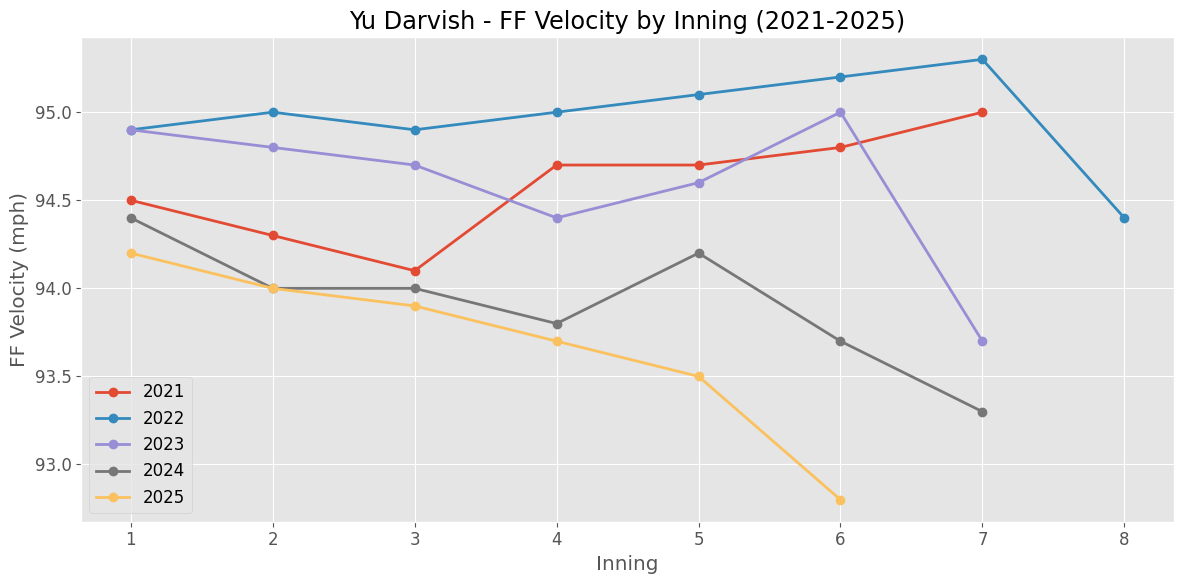


=== FF Velocity by Inning ===
season  2021  2022  2023  2024  2025
inning                              
1       94.5  94.9  94.9  94.4  94.2
2       94.3  95.0  94.8  94.0  94.0
3       94.1  94.9  94.7  94.0  93.9
4       94.7  95.0  94.4  93.8  93.7
5       94.7  95.1  94.6  94.2  93.5
6       94.8  95.2  95.0  93.7  92.8
7       95.0  95.3  93.7  93.3   NaN
8        NaN  94.4   NaN   NaN   NaN

=== Velocity Drop (1st inning → last inning) ===
  2021: 94.5 → 95.0 (inn 7) = +0.5 mph
  2022: 94.9 → 94.4 (inn 8) = -0.5 mph
  2023: 94.9 → 93.7 (inn 7) = -1.2 mph
  2024: 94.4 → 93.3 (inn 7) = -1.1 mph
  2025: 94.2 → 92.8 (inn 6) = -1.4 mph


In [8]:
# Fastball velocity by inning, per season
ff_type = 'FF' if 'FF' in top_pitches else top_pitches[0]

fatigue = con.execute(f"""
    SELECT
        season,
        inning,
        ROUND(AVG(release_speed), 1) as avg_velo,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type = '{ff_type}' AND inning <= 8
    GROUP BY season, inning
    HAVING COUNT(*) >= 5
    ORDER BY season, inning
""").df()

fig, ax = plt.subplots(figsize=(12, 6))

for year in YEARS:
    data = fatigue[fatigue['season'] == year]
    if len(data) > 0:
        ax.plot(data['inning'], data['avg_velo'], marker='o', label=str(year), linewidth=2)

ax.set_xlabel('Inning')
ax.set_ylabel(f'{ff_type} Velocity (mph)')
ax.set_title(f'Yu Darvish - {ff_type} Velocity by Inning (2021-2025)')
ax.set_xticks(range(1, 9))
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print(f'\n=== {ff_type} Velocity by Inning ===')
fatigue_pivot = fatigue.pivot_table(index='inning', columns='season', values='avg_velo')
print(fatigue_pivot.to_string())

# Velocity drop (1st inning vs last inning with data)
print(f'\n=== Velocity Drop (1st inning → last inning) ===')
for year in YEARS:
    data = fatigue[fatigue['season'] == year]
    if len(data) >= 2:
        first_velo = data.iloc[0]['avg_velo']
        last_velo = data.iloc[-1]['avg_velo']
        last_inn = int(data.iloc[-1]['inning'])
        drop = last_velo - first_velo
        print(f'  {year}: {first_velo} → {last_velo} (inn {last_inn}) = {drop:+.1f} mph')

## 7. Fatigue Pattern: Pitch Count Effect

In [9]:
# Velocity by pitch count within game, per season
pitch_count_effect = con.execute(f"""
    WITH pitch_seq AS (
        SELECT
            season,
            game_pk,
            release_speed,
            ROW_NUMBER() OVER(PARTITION BY game_pk ORDER BY at_bat_number, pitch_number) as pitch_num
        FROM df
        WHERE pitch_type = '{ff_type}'
    )
    SELECT
        season,
        CASE
            WHEN pitch_num <= 25 THEN '1-25'
            WHEN pitch_num <= 50 THEN '26-50'
            WHEN pitch_num <= 75 THEN '51-75'
            WHEN pitch_num <= 100 THEN '76-100'
            ELSE '100+'
        END as pitch_range,
        COUNT(*) as pitches,
        ROUND(AVG(release_speed), 1) as avg_velo
    FROM pitch_seq
    GROUP BY season, pitch_range
    ORDER BY season, pitch_range
""").df()

print('=== Velocity by Pitch Count in Game ===')
for year in YEARS:
    data = pitch_count_effect[pitch_count_effect['season'] == year]
    print(f'\n--- {year} ---')
    print(data[['pitch_range', 'pitches', 'avg_velo']].to_string(index=False))

=== Velocity by Pitch Count in Game ===

--- 2021 ---
pitch_range  pitches  avg_velo
       1-25      579      94.5
      26-50       33      94.1

--- 2022 ---
pitch_range  pitches  avg_velo
       1-25      657      95.0
      26-50      102      95.1

--- 2023 ---
pitch_range  pitches  avg_velo
       1-25      361      94.7
      26-50       10      93.7

--- 2024 ---
pitch_range  pitches  avg_velo
       1-25      230      94.1
      26-50        2      93.2

--- 2025 ---
pitch_range  pitches  avg_velo
       1-25      177      94.0
      26-50        8      92.7


## 8. Whiff Rate Evolution

**空振り率** = 空振り数 / スイング総数（空振り + ファウル + インプレー）

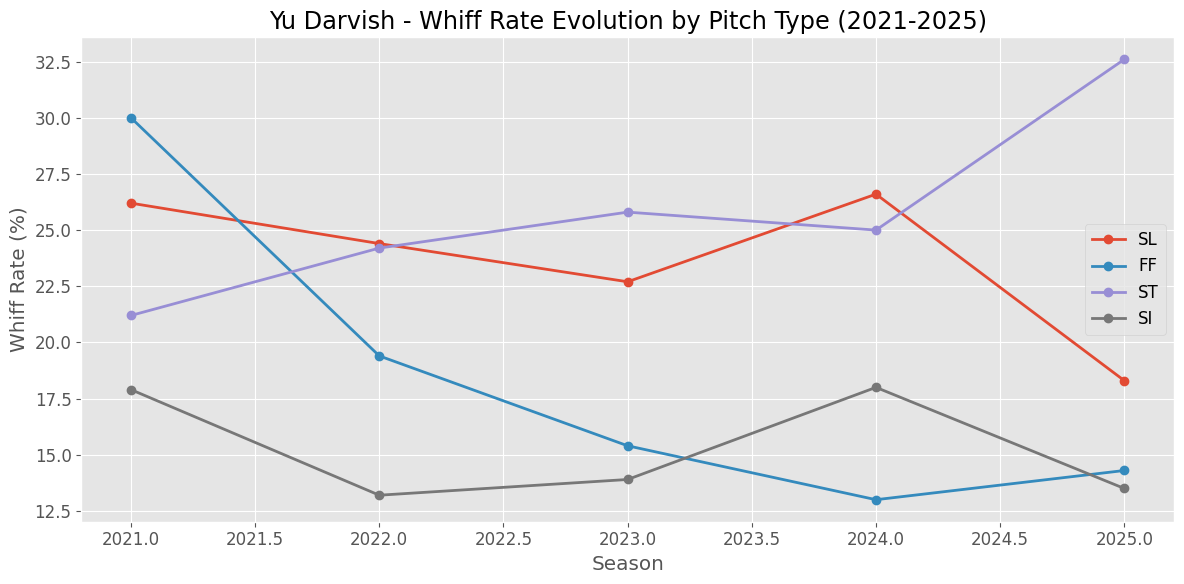


=== Whiff Rate by Pitch Type by Season ===
season      2021  2022  2023  2024  2025
pitch_type                              
CH           NaN   NaN   0.0  31.0  33.3
CU          29.2  26.8  44.0  41.1  33.8
FC           6.7  21.1  12.4  30.8  17.2
FF          30.0  19.4  15.4  13.0  14.3
FS          31.9  34.4  38.9  34.5  26.6
KC          31.6  29.3  36.4  25.0   0.0
SI          17.9  13.2  13.9  18.0  13.5
SL          26.2  24.4  22.7  26.6  18.3
ST          21.2  24.2  25.8  25.0  32.6

=== Whiff Rate Changes (2021 → 2025) ===
  SL: 26.2% → 18.3% (-7.9%)
  FF: 30.0% → 14.3% (-15.7%)
  ST: 21.2% → 32.6% (+11.4%)
  SI: 17.9% → 13.5% (-4.4%)


In [10]:
# Whiff rate by pitch type by season (FIXED: includes hit_into_play in denominator)
whiff = con.execute("""
    SELECT
        season,
        pitch_type,
        COUNT(*) as total_pitches,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) as whiffs,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END) as total_swings,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY season, pitch_type
    ORDER BY season, total_pitches DESC
""").df()

# Chart: whiff rate for top pitches across years
fig, ax = plt.subplots(figsize=(12, 6))

for pitch in top_pitches:
    data = whiff[whiff['pitch_type'] == pitch]
    if len(data) > 0:
        ax.plot(data['season'], data['whiff_rate'], marker='o', label=pitch, linewidth=2)

ax.set_xlabel('Season')
ax.set_ylabel('Whiff Rate (%)')
ax.set_title('Yu Darvish - Whiff Rate Evolution by Pitch Type (2021-2025)')
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Whiff Rate by Pitch Type by Season ===')
whiff_pivot = whiff.pivot_table(index='pitch_type', columns='season', values='whiff_rate')
print(whiff_pivot.round(1).to_string())

# Changes
print(f'\n=== Whiff Rate Changes ({YEARS[0]} → {YEARS[-1]}) ===')
for pitch in top_pitches:
    data = whiff[whiff['pitch_type'] == pitch]
    if len(data) >= 2:
        first_val = data[data['season'] == YEARS[0]]['whiff_rate'].values
        last_val = data[data['season'] == YEARS[-1]]['whiff_rate'].values
        if len(first_val) > 0 and len(last_val) > 0:
            change = last_val[0] - first_val[0]
            print(f'  {pitch}: {first_val[0]:.1f}% → {last_val[0]:.1f}% ({change:+.1f}%)')

## 9. Two-Strike Strategy Evolution

2ストライクからの「決め球」がどう変わったか

In [11]:
# Two-strike pitch selection by season
two_strike = con.execute("""
    SELECT
        season,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY season), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE strikes = 2 AND pitch_type IS NOT NULL
    GROUP BY season, pitch_type
    ORDER BY season, pitches DESC
""").df()

print('=== Two-Strike Pitch Selection by Season ===')
for year in YEARS:
    data = two_strike[two_strike['season'] == year].head(5)
    print(f'\n--- {year} ---')
    print(data[['pitch_type', 'pitches', 'pct', 'whiff_rate']].to_string(index=False))

=== Two-Strike Pitch Selection by Season ===

--- 2021 ---
pitch_type  pitches  pct  whiff_rate
        ST      221 25.6        21.7
        FF      211 24.4        29.5
        SL      133 15.4        19.4
        FS      108 12.5        33.9
        SI       89 10.3        22.7

--- 2022 ---
pitch_type  pitches  pct  whiff_rate
        FF      298 32.8        22.8
        FS      160 17.6        32.7
        ST      146 16.1        18.7
        SL      132 14.5        23.1
        KC       75  8.3        28.8

--- 2023 ---
pitch_type  pitches  pct  whiff_rate
        FF      148 22.4        16.3
        FS      118 17.9        36.2
        SI      103 15.6         8.9
        ST       95 14.4        27.6
        KC       70 10.6        37.5

--- 2024 ---
pitch_type  pitches  pct  whiff_rate
        FF       83 21.2        17.0
        SL       78 19.9        22.6
        ST       59 15.1        29.4
        SI       51 13.0        13.3
        CH       32  8.2        33.3

--- 2025 -

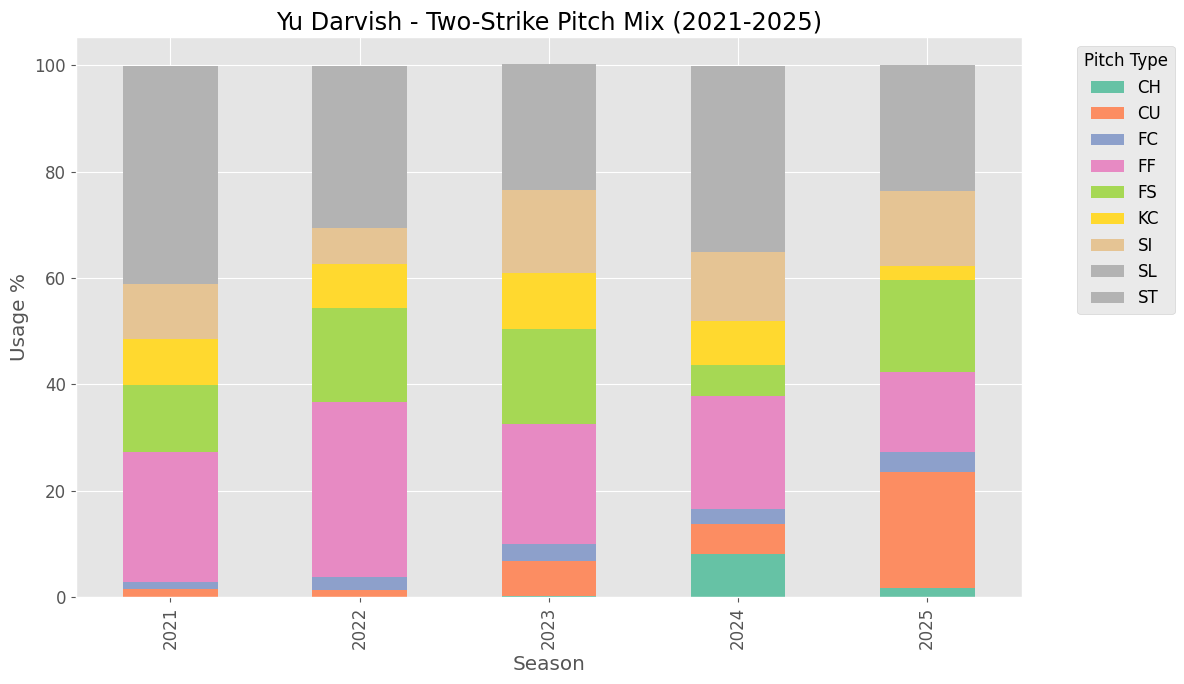


=== Two-Strike Mix Changes ===
pitch_type   CH    CU   FC    FF    FS    KC    SI    SL    ST
season                                                        
2021        0.0   1.5  1.4  24.4  12.5   8.8  10.3  15.4  25.6
2022        0.0   1.4  2.5  32.8  17.6   8.3   6.7  14.5  16.1
2023        0.2   6.7  3.2  22.4  17.9  10.6  15.6   9.2  14.4
2024        8.2   5.6  2.8  21.2   5.9   8.2  13.0  19.9  15.1
2025        1.7  21.8  3.8  15.1  17.2   2.6  14.2  13.7   9.9


In [12]:
# Two-strike pitch mix change chart
ts_pivot = two_strike.pivot_table(index='season', columns='pitch_type', values='pct', fill_value=0)

ts_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set2')
plt.title('Yu Darvish - Two-Strike Pitch Mix (2021-2025)')
plt.xlabel('Season')
plt.ylabel('Usage %')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Two-Strike Mix Changes ===')
print(ts_pivot.round(1).to_string())

## 10. Count Situation Analysis

In [13]:
# Count-based pitch selection (FIXED: Full Count checked before Behind)
count_analysis = con.execute("""
    SELECT
        season,
        CASE
            WHEN balls = 3 AND strikes = 2 THEN 'Full Count'
            WHEN balls > strikes THEN 'Behind'
            WHEN strikes > balls THEN 'Ahead'
            ELSE 'Even'
        END as count_situation,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(
            PARTITION BY season,
            CASE
                WHEN balls = 3 AND strikes = 2 THEN 'Full Count'
                WHEN balls > strikes THEN 'Behind'
                WHEN strikes > balls THEN 'Ahead'
                ELSE 'Even'
            END
        ), 1) as pct
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY season, count_situation, pitch_type
    ORDER BY season, count_situation, pitches DESC
""").df()

# Show top 3 pitches per situation per year
print('=== Pitch Selection by Count Situation ===')
for year in YEARS:
    print(f'\n=== {year} ===')
    for situation in ['Ahead', 'Even', 'Behind', 'Full Count']:
        data = count_analysis[
            (count_analysis['season'] == year) &
            (count_analysis['count_situation'] == situation)
        ].head(3)
        if len(data) > 0:
            top_str = ', '.join([f"{r['pitch_type']} {r['pct']}%" for _, r in data.iterrows()])
            print(f'  {situation}: {top_str}')

=== Pitch Selection by Count Situation ===

=== 2021 ===
  Ahead: FF 32.8%, ST 15.9%, FS 12.9%
  Even: SL 30.3%, ST 25.1%, FF 23.1%
  Behind: SL 61.8%, ST 23.1%, FF 7.6%
  Full Count: SL 40.7%, ST 40.7%, FF 9.0%

=== 2022 ===
  Ahead: FF 35.6%, FS 16.9%, ST 12.3%
  Even: SL 32.2%, FF 25.8%, ST 17.6%
  Behind: SL 64.4%, ST 12.6%, FF 11.3%
  Full Count: SL 45.2%, ST 27.4%, FF 10.4%

=== 2023 ===
  Ahead: FF 24.1%, FS 19.4%, SI 14.0%
  Even: SI 21.5%, ST 19.2%, FF 17.5%
  Behind: SL 37.5%, ST 26.9%, SI 17.0%
  Full Count: SI 27.7%, ST 21.3%, KC 18.1%

=== 2024 ===
  Ahead: FF 21.1%, SL 16.0%, SI 14.3%
  Even: SL 21.5%, FF 19.5%, SI 17.9%
  Behind: SL 38.8%, SI 17.6%, ST 13.2%
  Full Count: SL 30.2%, SI 25.4%, ST 20.6%

=== 2025 ===
  Ahead: CU 20.3%, FS 18.9%, SI 13.7%
  Even: SI 23.0%, FF 17.5%, CU 15.2%
  Behind: SL 23.8%, SI 21.7%, FC 17.5%
  Full Count: SI 25.5%, FF 16.4%, SL 16.4%


## 11. Summary

In [14]:
print('=' * 60)
print('YU DARVISH 2021-2025 EVOLUTION SUMMARY')
print('=' * 60)

# Games & Pitches
print('\n[Workload]')
for _, row in summary.iterrows():
    print(f'  {int(row["season"])}: {int(row["games"])} games, {int(row["pitches"]):,} pitches, avg {row["avg_velo"]} mph')

# Pitch mix biggest changes
print(f'\n[Pitch Mix Changes ({YEARS[0]} → {YEARS[-1]})]')
if len(YEARS) >= 2:
    first = mix_pivot.loc[YEARS[0]]
    last = mix_pivot.loc[YEARS[-1]]
    diff = (last - first).sort_values()
    for pitch, change in diff.items():
        if abs(change) >= 2.0:
            direction = 'increased' if change > 0 else 'decreased'
            print(f'  {pitch}: {direction} by {abs(change):.1f}% ({first[pitch]:.1f}% → {last[pitch]:.1f}%)')

# Velocity trend
print(f'\n[Fastball Velocity Trend]')
ff_yearly = velo_by_year[velo_by_year['pitch_type'] == ff_type]
for _, row in ff_yearly.iterrows():
    print(f'  {int(row["season"])}: {row["avg_velo"]} mph ({int(row["count"])} pitches)')

# Best whiff pitch per year
print(f'\n[Best Whiff Rate Pitch per Year]')
for year in YEARS:
    year_whiff = whiff[(whiff['season'] == year) & (whiff['total_swings'] >= 30)]
    if len(year_whiff) > 0:
        best = year_whiff.loc[year_whiff['whiff_rate'].idxmax()]
        print(f'  {year}: {best["pitch_type"]} ({best["whiff_rate"]}%)')

print('\n' + '=' * 60)

YU DARVISH 2021-2025 EVOLUTION SUMMARY

[Workload]
  2021: 30 games, 2,773 pitches, avg 87.0 mph
  2022: 30 games, 2,971 pitches, avg 88.2 mph
  2023: 24 games, 2,219 pitches, avg 87.8 mph
  2024: 16 games, 1,264 pitches, avg 87.2 mph
  2025: 15 games, 1,160 pitches, avg 86.7 mph

[Pitch Mix Changes (2021 → 2025)]
  SL: decreased by 16.1% (31.0% → 14.9%)
  ST: decreased by 13.7% (22.8% → 9.1%)
  FF: decreased by 6.1% (22.1% → 16.0%)
  KC: decreased by 2.6% (3.8% → 1.2%)
  FS: increased by 5.7% (4.9% → 10.6%)
  FC: increased by 9.7% (2.5% → 12.2%)
  CU: increased by 10.8% (4.6% → 15.4%)
  SI: increased by 11.7% (8.3% → 20.0%)

[Fastball Velocity Trend]
  2021: 94.5 mph (612 pitches)
  2022: 95.0 mph (759 pitches)
  2023: 94.7 mph (371 pitches)
  2024: 94.1 mph (232 pitches)
  2025: 93.9 mph (185 pitches)

[Best Whiff Rate Pitch per Year]
  2021: FS (31.9%)
  2022: FS (34.4%)
  2023: CU (44.0%)
  2024: CU (41.1%)
  2025: CU (33.8%)

